In [26]:
import json
import os
import numpy as np
import time
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision
import seaborn as sns
from numpy import array

import matplotlib.pyplot as plt
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [3]:
def make_binary(row):
    label =  row['label']
    
    if label == 'food':
        return 1
    else:
        return 0
    
# Read in the json file as a python dict using photo_id as key
def create_mapping(path):
    yelp_data = {}
    with open(path) as file:
        for line in file:
            cur_img = json.loads(line)
            yelp_data[cur_img['photo_id']] = cur_img
            
    # Convert yelp_data into dataframe
    df = pd.DataFrame.from_dict(yelp_data, 'index')

    # Add binary label for 'food' vs 'not food'
    df['is_food'] = df.apply(make_binary, axis = 1)
    
    return df, yelp_data

# ratio is a list of three integers that sum to 100. e.g. [60,20,20]
def split_train_dev_test(df, ratio):
    
    data_size = len(df)
    train_split = int((ratio[0] / float(100)) * data_size)
    dev_split = int(((ratio[0] + ratio[1])  / float(100)) * data_size)
    
    train = df[:train_split]
    dev = df[train_split:dev_split]
    test = df[dev_split:]
    
    df['data'] = ''
    df['data'][:train_split] = 'train'
    df['data'][train_split:dev_split] = 'dev'
    df['data'][dev_split:] = 'test'
    
    
    return train, dev, test
    

In [4]:
# Convert images into a list of numpy arrays, and a list of integers
def read_image(all_photo_name, path, label, df, binary = True):
    
    
    np_labels = []
    np_imgs = []

    start_time = time.time()
    
    
    for idx, p in enumerate(all_photo_name):
        
        if (idx % 1000 == 0):
            print('number of photos processed:', idx)
            time_elapsed = time.time() - start_time
            print('time elapsed:{:5.2f} seconds'.format(time_elapsed))
        
        if (p != '.DS_Store'):
            data = plt.imread(path + p + '.jpg')
            image_resized = resize(data, (128, 128))
            image_reshaped = image_resized.transpose()
            np_imgs.append(image_reshaped)
            p_id = p
            
            if label == 'stars':
                star = df[df['photo_id'] == p_id]['stars'].values
            
                
                if star > 4:
                    np_labels.append(1)                
                elif star < 3:
                    np_labels.append(0)
                else:
                    np_imgs = np_imgs[:-1]

            elif label == 'type':
                rest_type = df[df['photo_id'] == p_id]['type'].values
            
                np_labels.append(rest_type)
                
                
            else:
                if yelp_data[p_id]['label'] == 'food':          
                    np_labels.append(1)

                else:
                    if binary:
                        np_labels.append(0)
                    else:            
                        if yelp_data[p_id]['label'] == 'drink':
                            np_labels.append(0)
                        elif yelp_data[p_id]['label'] == 'inside':
                            np_labels.append(2)
                        elif yelp_data[p_id]['label'] == 'outside':
                            np_labels.append(3)
                        else:
                            np_labels.append(4)

    imgs_npy = np.asarray(np_imgs)
    label_npy = np.asarray(np_labels)
    
    
    print('finished!')
    time_elapsed = time.time() - start_time
    print('time elapsed:{:5.2f} seconds'.format(time_elapsed))
    
    return imgs_npy, label_npy

In [65]:
class Dataset(Dataset):
    def __init__(self, imgs_npy, label_npy, train=True, normalize=False):
        """
        """
        X = imgs_npy.astype(float)
        y = label_npy.astype(float)  
        print(X.shape)
        if normalize:
            for index, img in enumerate(X):
                img_mean = img.mean()
                img_std = img.std()
                img = (img - img_mean) / img_std
                X[index] = img
            
        self.len = X.shape[0]
        self.x_data = torch.from_numpy(X).float()
        self.y_data = torch.from_numpy(y).float()

    def __len__(self):
        
        return self.len

    def __getitem__(self, idx):
        
        return self.x_data[idx], self.y_data[idx]

In [79]:
def train_accuracy(net, train_loader, option=0):
    
    start_time = time.time()

    # Specify the loss function
    criterion = nn.CrossEntropyLoss()

    # Specify the optimizer
    optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9, weight_decay=5e-4)

    max_epochs = 20

    # loss_np = np.zeros((max_epochs))
    accuracy = np.zeros((max_epochs))

    for epoch in range(max_epochs):
        print('epoch:', epoch)
        time_elapsed = time.time() - start_time
        print('time elapsed:{:5.2f} seconds'.format(time_elapsed))
 
        tot_correct = 0
        tot_len = 0
        for i, data in enumerate(train_loader, 0):
            
            
            # Get inputs and labels from data loader 
            inputs, labels = data
            inputs, labels = Variable(inputs), Variable(labels).long()

            # Feed the input data into the network 
            y_pred = net(inputs)
        
            # Calculate the loss using predicted labels and ground truth labels
            if option == 0:
                loss = criterion(y_pred, labels)
            else:
                loss = criterion(y_pred, torch.squeeze(labels))
            # zero gradient
            optimizer.zero_grad()

            # backpropogates to compute gradient
            loss.backward()

            # updates the weghts
            optimizer.step()

            # convert predicted laels into numpy
            y_pred_np = y_pred.data.numpy()

            # calculate the training accuracy of the current model
            pred_np = np.argmax(y_pred_np, axis=1)
            label_np = labels.data.numpy().reshape(len(labels),1)

            pred_np = pred_np.reshape(len(pred_np), 1)

            correct=0
            for j in range(y_pred_np.shape[0]):
                if pred_np[j,:] == label_np[j,:]:
                    correct += 1

            tot_len+=1
            tot_correct+= float(correct)/float(len(label_np))
#             tot_loss+= loss.data.numpy()

        accuracy[epoch] = float(tot_correct)/float(tot_len)
#         loss_np[epoch] = tot_loss / tot_len
        print('epoch {} accuracy: {:5.2f}'.format(epoch, accuracy[epoch]))


    print("final training accuracy: ", accuracy[max_epochs-1])

    epoch_number = np.arange(0,max_epochs,1)

    # Plot the training accuracy over epoch
    plt.figure()
    plt.plot(epoch_number, accuracy)
    plt.title('training accuracy over epoches')
    plt.xlabel('Number of Epoch')
    plt.ylabel('accuracy')
    plt.show()


In [39]:
def test_accuracy(net, test_loader):
    start_time = time.time()
    
    tot_correct = 0
    tot_len = 0
    
    pred_labels = []
    true_labels = []
    
    for i, test_data in enumerate(test_loader, 0):
        # Get inputs and labels from data loader 
        inputs, labels = test_data
        inputs, labels = Variable(inputs), Variable(labels).long()

        # Feed the input data into the network 
        y_pred = net(inputs)

        y_pred_np = y_pred.data.numpy()
        
        # calculate the training accuracy of the current model
        pred_np = np.argmax(y_pred_np, axis=1)
        label_np = labels.data.numpy().reshape(len(labels),1)

        pred_np = pred_np.reshape(len(pred_np), 1)

        correct=0
        
        pred_labels += np.squeeze(pred_np).tolist()
        true_labels += np.squeeze(label_np).tolist()
        
        for j in range(y_pred_np.shape[0]):
            if pred_np[j,:] == label_np[j,:]:
                correct += 1

        tot_len+=1
        tot_correct+= float(correct)/float(len(label_np))
#         tot_loss += loss.data.numpy()
    
    test_accuracy = float(tot_correct)/float(tot_len)
    print('test accuracy:{:5.4f}'.format(test_accuracy))
    
    time_elapsed = time.time() - start_time
    print('time elapsed:{:5.4f} seconds'.format(time_elapsed))
    
    f1 = f1_score(true_labels, pred_labels, average='macro')
    precision = precision_score(true_labels, pred_labels, average='macro')
    recall = recall_score(true_labels, pred_labels, average='macro')
    print('f1_score: {:5.4f}'.format(f1))
    print('precision: {:5.4f}'.format(precision))
    print('recall: {:5.4f}'.format(recall))
    return pred_labels, true_labels, test_accuracy

In [8]:
df, yelp_data = create_mapping('photos.json')

In [11]:
#Preprocessing
def merge_star(df, food_only=False, star=False, types=False):
    print('len before processing:', len(df))
    stars = pd.read_pickle('stars.pickle')
    df = pd.merge(left=df, right=stars, how='left', on='business_id')
    if types:
        df = df[~df['type'].isnull()]
    if food_only:
        df = df[df['label'] == 'food']
    if star:
        bad = df['stars'] < 3
        good = df['stars'] > 4
        df = df[bad | good]
    print('len after processing:', len(df))
    return df

In [57]:
df_food = merge_star(df)
df_star = merge_star(df, True, True, False)
df_cat = merge_star(df, True, False, True)

len before processing: 206949
len after processing: 206949
len before processing: 206949
len after processing: 36425
len before processing: 206949
len after processing: 54075


In [58]:
train_food, dev_food, test_food = split_train_dev_test(df_food, [60, 20, 20])
train_star, dev_star, test_star = split_train_dev_test(df_star, [60, 20, 20])
train_cat, dev_cat, test_cat = split_train_dev_test(df_cat, [60, 20, 20])

/Users/Eddie/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Eddie/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Eddie/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [59]:
# Get all the file names of photos
train_star_photos = train_star['photo_id'].tolist()[:3000]
test_star_photos = dev_star['photo_id'].tolist()[:1000]
train_food_photos = train_food['photo_id'].tolist()[:3000]
test_food_photos = dev_food['photo_id'].tolist()[:1000]
train_cat_photos = train_cat['photo_id'].tolist()[:3000]
test_cat_photos = dev_cat['photo_id'].tolist()[:1000]

In [60]:
df_food.pivot_table(values='business_id', index='type', columns='data', aggfunc=len, margins=True)

data,dev,test,train,All
type,,,,
0.0,631,653,1866,3150
1.0,3166,3140,9522,15828
2.0,2303,2326,6966,11595
3.0,3372,3369,9992,16733
4.0,5371,5294,15523,26188
All,14843,14782,43869,73494


/Users/Eddie/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


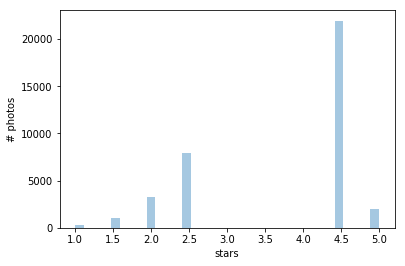

In [61]:
sns.distplot(df_star['stars'], kde=False)
plt.ylabel('# photos')
plt.show()

/Users/Eddie/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


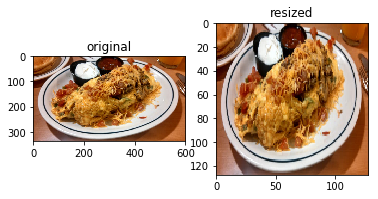

In [20]:
# Plot the resized first image in dataset

sample_photo = train_food_photos[3]

f, ax = plt.subplots(1,2)

test_data = plt.imread('photos/' + sample_photo + '.jpg')
resized_data = resize(test_data, (128, 128))

ax[0].imshow(test_data)
ax[0].set_title('original')

ax[1].imshow(resized_data)
ax[1].set_title('resized')

plt.show()

In [21]:
# # Visualize the dataset
def imshow(img, data_loader):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.title('Visualize the dataset')
    plt.imshow(np.transpose(npimg))
#     plt.imshow(np.transpose(npimg, (1, 2, 0))/255)

In [22]:
# Simple neural network
class Net(nn.Module):
    def __init__(self, num_classes=2):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(128*128*3, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
    

    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = F.sigmoid(self.fc1(x))
        out = F.sigmoid(self.fc2(out))
        
        return out

In [23]:
class CNet(nn.Module):
    def __init__(self, num_classes=2):
        super(CNet, self).__init__()
        # 3 input image channel, 10 output channels, 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(3, 10, 5, 1, 0)
        # Max pooling over a (2, 2) window
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(10, 20, 5, 1, 0)
        self.fc1 = nn.Linear(20*58*58, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.pool(out)
        out = F.relu(self.conv2(out))
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.sigmoid(self.fc2(out))
        
        return out

In [24]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo


__all__ = ['AlexNet', 'alexnet']


model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}


class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 3 * 3, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 3 * 3)
        x = self.classifier(x)
        return x


def alexnet(pretrained=False, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = AlexNet(**kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['alexnet']))
    return model

## 1. Test on binary data(Food or Not Food)

In [25]:
train_imgs_npy, train_label_npy = read_image(train_food_photos, 'photos/', 'isfood', df_food)
test_imgs_npy, test_label_npy = read_image(test_food_photos, 'photos/', 'isfood', df_food)

# Specify the training dataset
train_dataset = Dataset(train_imgs_npy, train_label_npy)
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=128,
                          shuffle=True)

# Specify the test dataset
test_dataset = Dataset(test_imgs_npy, test_label_npy)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=128,
                          shuffle=True)

number of photos processed: 0
time elapsed: 0.00 seconds


/Users/Eddie/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


number of photos processed: 1000
time elapsed:16.42 seconds
number of photos processed: 2000
time elapsed:36.87 seconds
finished!
time elapsed:57.32 seconds
number of photos processed: 0
time elapsed: 0.00 seconds
finished!
time elapsed:14.57 seconds
(3000, 3, 128, 128)
(1000, 3, 128, 128)


epoch: 0
time elapsed: 0.00 seconds
epoch 0 accuracy:  0.63
epoch: 1
time elapsed:13.58 seconds
epoch 1 accuracy:  0.68
epoch: 2
time elapsed:27.74 seconds
epoch 2 accuracy:  0.75
epoch: 3
time elapsed:39.39 seconds
epoch 3 accuracy:  0.77
epoch: 4
time elapsed:51.26 seconds
epoch 4 accuracy:  0.79
epoch: 5
time elapsed:64.58 seconds
epoch 5 accuracy:  0.81
epoch: 6
time elapsed:81.48 seconds
epoch 6 accuracy:  0.82
epoch: 7
time elapsed:97.51 seconds
epoch 7 accuracy:  0.82
epoch: 8
time elapsed:110.46 seconds
epoch 8 accuracy:  0.83
epoch: 9
time elapsed:124.58 seconds
epoch 9 accuracy:  0.83
epoch: 10
time elapsed:137.51 seconds
epoch 10 accuracy:  0.83
epoch: 11
time elapsed:149.81 seconds
epoch 11 accuracy:  0.84
epoch: 12
time elapsed:164.89 seconds
epoch 12 accuracy:  0.84
epoch: 13
time elapsed:178.25 seconds
epoch 13 accuracy:  0.85
epoch: 14
time elapsed:191.54 seconds
epoch 14 accuracy:  0.84
epoch: 15
time elapsed:206.28 seconds
epoch 15 accuracy:  0.85
epoch: 16
time elaps

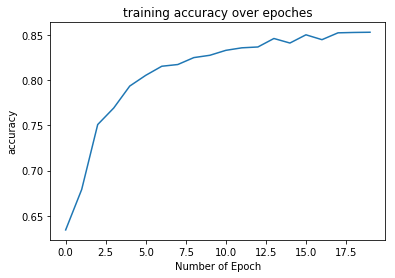

In [28]:
net = Net(num_classes=2)
train_accuracy(net, train_loader)

In [40]:
test_acc = test_accuracy(net, test_loader)

test accuracy:0.8381
time elapsed:1.2257 seconds
f1_score: 0.8195
precision: 0.8343
recall: 0.8107


epoch: 0
time elapsed: 0.00 seconds
epoch 0 accuracy:  0.62
final training accuracy:  0.6205357142857143


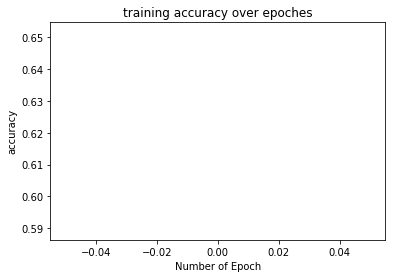

In [44]:
cnet = CNet(2)
train_accuracy(cnet, train_loader)

In [45]:
test_acc = test_accuracy(cnet, test_loader)

test accuracy:0.6300
time elapsed:9.6320 seconds
f1_score: 0.3861
precision: 0.3145
recall: 0.5000


/Users/Eddie/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Eddie/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## 2. Predicting stars

In [62]:
train_imgs_npy, train_label_npy = read_image(train_star_photos, 'photos/', 'stars', df_star, binary=False)
test_imgs_npy, test_label_npy = read_image(test_star_photos, 'photos/', 'stars', df_star, binary=False)

number of photos processed: 0
time elapsed: 0.00 seconds


/Users/Eddie/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


number of photos processed: 1000
time elapsed:24.36 seconds
number of photos processed: 2000
time elapsed:47.16 seconds
finished!
time elapsed:73.76 seconds
number of photos processed: 0
time elapsed: 0.00 seconds
finished!
time elapsed:23.98 seconds


In [66]:
# Specify the training dataset
train_dataset = Dataset(train_imgs_npy, train_label_npy)
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=128,
                          shuffle=True)

# Specify the test dataset
test_dataset = Dataset(test_imgs_npy, test_label_npy)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=128,
                          shuffle=True)

(3000, 3, 128, 128)
(1000, 3, 128, 128)


In [52]:
len(test_label_npy)

277

epoch: 0
time elapsed: 0.00 seconds
epoch 0 accuracy:  0.65
final training accuracy:  0.6520182291666666


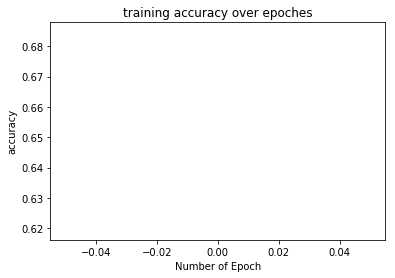

test accuracy:0.6638
time elapsed:1.2631 seconds
f1_score: 0.3994
precision: 0.3325
recall: 0.5000


/Users/Eddie/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Eddie/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [68]:
net = Net(num_classes=2)
train_accuracy(net, train_loader)
test_acc = test_accuracy(net, test_loader)

epoch: 0
time elapsed: 0.00 seconds
epoch 0 accuracy:  0.52
epoch: 1
time elapsed:26.62 seconds
epoch 1 accuracy:  0.55
epoch: 2
time elapsed:45.54 seconds
epoch 2 accuracy:  0.55
epoch: 3
time elapsed:69.41 seconds
epoch 3 accuracy:  0.55
epoch: 4
time elapsed:89.82 seconds
epoch 4 accuracy:  0.56
epoch: 5
time elapsed:115.69 seconds
epoch 5 accuracy:  0.57
epoch: 6
time elapsed:137.98 seconds
epoch 6 accuracy:  0.54
epoch: 7
time elapsed:155.99 seconds
epoch 7 accuracy:  0.54
epoch: 8
time elapsed:173.28 seconds
epoch 8 accuracy:  0.53
epoch: 9
time elapsed:191.94 seconds
epoch 9 accuracy:  0.58
epoch: 10
time elapsed:209.58 seconds
epoch 10 accuracy:  0.54
epoch: 11
time elapsed:226.82 seconds
epoch 11 accuracy:  0.54
epoch: 12
time elapsed:247.23 seconds
epoch 12 accuracy:  0.58
epoch: 13
time elapsed:264.48 seconds
epoch 13 accuracy:  0.58
epoch: 14
time elapsed:286.07 seconds
epoch 14 accuracy:  0.59
epoch: 15
time elapsed:307.94 seconds
epoch 15 accuracy:  0.62
epoch: 16
time el

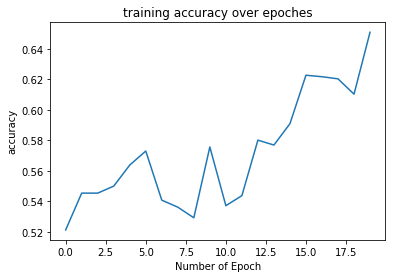

test accuracy: 0.61
time elapsed: 2.36 seconds


In [46]:
cnet = CNet(num_classes=2)
train_accuracy(cnet, train_loader)
test_acc = test_accuracy(cnet, test_loader)

epoch: 0
time elapsed: 0.00 seconds
epoch 0 accuracy:  0.47
epoch: 1
time elapsed:18.95 seconds
epoch 1 accuracy:  0.54
epoch: 2
time elapsed:38.15 seconds
epoch 2 accuracy:  0.53
epoch: 3
time elapsed:57.85 seconds
epoch 3 accuracy:  0.55
epoch: 4
time elapsed:75.79 seconds
epoch 4 accuracy:  0.54
epoch: 5
time elapsed:95.40 seconds
epoch 5 accuracy:  0.52
epoch: 6
time elapsed:115.66 seconds
epoch 6 accuracy:  0.55
epoch: 7
time elapsed:134.21 seconds
epoch 7 accuracy:  0.55
epoch: 8
time elapsed:154.55 seconds
epoch 8 accuracy:  0.55
epoch: 9
time elapsed:173.93 seconds
epoch 9 accuracy:  0.54
epoch: 10
time elapsed:193.90 seconds
epoch 10 accuracy:  0.53
epoch: 11
time elapsed:222.79 seconds
epoch 11 accuracy:  0.54
epoch: 12
time elapsed:243.79 seconds
epoch 12 accuracy:  0.53
epoch: 13
time elapsed:274.38 seconds
epoch 13 accuracy:  0.56
epoch: 14
time elapsed:297.45 seconds
epoch 14 accuracy:  0.55
epoch: 15
time elapsed:316.77 seconds
epoch 15 accuracy:  0.53
epoch: 16
time ela

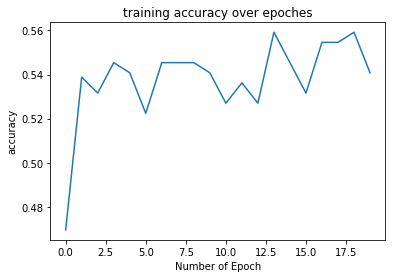

test accuracy: 0.54
time elapsed: 2.75 seconds


In [47]:
alex_net = AlexNet(num_classes=2)
train_accuracy(alex_net, train_loader)
test_acc = test_accuracy(alex_net, test_loader)

## 3. Predicting restaurant categories

In [70]:
train_imgs_npy, train_label_npy = read_image(train_cat_photos, 'photos/', 'type', df_cat, binary=False)
test_imgs_npy, test_label_npy = read_image(test_cat_photos, 'photos/', 'type', df_cat, binary=False)

number of photos processed: 0
time elapsed: 0.00 seconds


/Users/Eddie/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


number of photos processed: 1000
time elapsed:28.19 seconds
number of photos processed: 2000
time elapsed:58.53 seconds
finished!
time elapsed:91.41 seconds
number of photos processed: 0
time elapsed: 0.00 seconds
finished!
time elapsed:26.35 seconds


In [71]:
# Specify the training dataset
train_dataset = Dataset(train_imgs_npy, train_label_npy.astype(int))
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=128,
                          shuffle=True)

# Specify the test dataset
test_dataset = Dataset(test_imgs_npy, test_label_npy.astype(int))
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=128,
                          shuffle=True)

(3000, 3, 128, 128)
(1000, 3, 128, 128)


epoch: 0
time elapsed: 0.01 seconds
epoch 0 accuracy:  0.31
final training accuracy:  0.3052920386904762


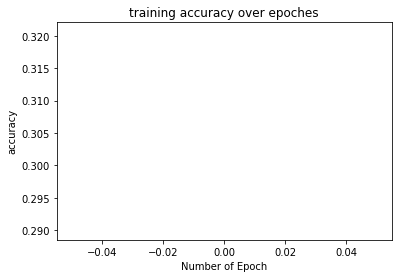

test accuracy:0.3277
time elapsed:1.6320 seconds
f1_score: 0.0988
precision: 0.0656
recall: 0.2000


/Users/Eddie/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Eddie/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [72]:
net = Net(num_classes=5)
train_accuracy(net, train_loader, option=1)
test_acc = test_accuracy(net, test_loader)

epoch: 0
time elapsed: 0.00 seconds
epoch 0 accuracy:  0.29
final training accuracy:  0.29464285714285715


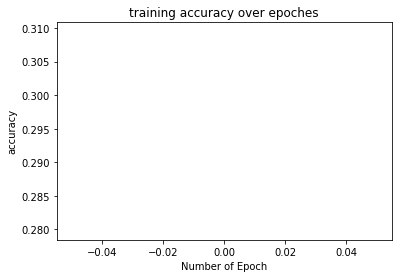

test accuracy:0.3287
time elapsed:9.7673 seconds
f1_score: 0.0988
precision: 0.0656
recall: 0.2000


/Users/Eddie/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Eddie/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [78]:
cnet = CNet(num_classes=5)
train_accuracy(cnet, train_loader, option=1)
test_acc = test_accuracy(cnet, test_loader)

In [ ]:
alex_net = AlexNet(num_classes=5)
train_accuracy(alex_net, train_loader, option=1)
test_acc = test_accuracy(alex_net, test_loader)

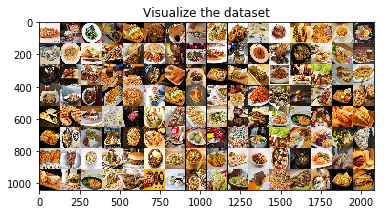

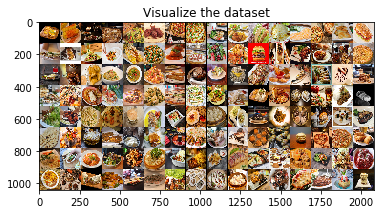

In [35]:
# get some random training images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images), train_loader)
# plt.imshow(resized_data)

plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images), test_loader)
# plt.imshow(resized_data)

plt.show()